### To do:
- delete month + distance variables
- validate model
- change weekend to friday 20:00 in data preparation
-

In [98]:
"""
Authors:
Group:
Description: this file will be used for clustering
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as datetime
import pyarrow.parquet as pq
import seaborn as sb
from sklearn.cluster import KMeans 
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import lightgbm as lgbm
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#from sklearn import cluster
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from matplotlib import pyplot

In [32]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor

In [48]:
import seaborn as sns

In [2]:
#import data
pq_taxi = pq.read_table("yellow_tripdata_processed.parquet")
df_taxi = pq_taxi.to_pandas()

Predict:
    - fare amount
    - trip duration
   
   
  - Attributes need to be numerical 
  - We need the year, month, date, day of week, hour etc. 
  - dropoff_longitude & dropoff_latitude (or code the zone's?) --> better to work with latitude and longitude. Coding the zone's will be very confusing as there are many zone's. 
  
  
  Columns:
  - pickup_longitude
  - pickup_latitude
  - dropoff_longitude
  - dropoff_latitude
  - passenger count
  - year
  - month
  - date
  - day of week
  - hour
  - distance
  
  (['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'H_Distance', 'Year', 'Month', 'Date', 'Day of Week', 'Hour'],

In [4]:
df_taxi.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,...,pickup_time,dropoff_time,trip_duration_seconds,trip_duration_minutes,pickup_hour,pickup_month,pickup_day_no,day_of_week,pickup_zone,dropoff_zone
0,2022-03-01 00:13:08,2022-03-01 00:24:35,1.0,2.40,1.0,90,209,10.0,0.00,13.80,...,00:13:08,00:24:35,687.0,11.0,0,3,1,Weekday,Flatiron,Seaport
1,2022-03-01 00:47:52,2022-03-01 01:00:08,1.0,2.20,1.0,148,234,10.5,0.00,14.30,...,00:47:52,01:00:08,736.0,12.0,0,3,1,Weekday,Lower East Side,Union Sq
2,2022-03-01 00:02:46,2022-03-01 00:46:43,1.0,19.78,2.0,132,249,52.0,11.06,67.61,...,00:02:46,00:46:43,2637.0,43.0,0,3,1,Weekday,JFK Airport,West Village
3,2022-03-01 00:52:43,2022-03-01 01:03:40,2.0,2.94,1.0,211,66,11.0,4.44,19.24,...,00:52:43,01:03:40,657.0,10.0,0,3,1,Weekday,SoHo,DUMBO/Vinegar Hill
4,2022-03-01 00:15:35,2022-03-01 00:34:13,1.0,8.57,1.0,138,197,25.0,5.51,33.06,...,00:15:35,00:34:13,1118.0,18.0,0,3,1,Weekday,LaGuardia Airport,Richmond Hill


In [5]:
df_taxi.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'fare_amount', 'tip_amount', 'total_amount', 'tip_percent',
       'pickup_date', 'dropoff_date', 'pickup_time', 'dropoff_time',
       'trip_duration_seconds', 'trip_duration_minutes', 'pickup_hour',
       'pickup_month', 'pickup_day_no', 'day_of_week', 'pickup_zone',
       'dropoff_zone'],
      dtype='object')

In [6]:
df_taxi.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
fare_amount                     float64
tip_amount                      float64
total_amount                    float64
tip_percent                     float64
pickup_date                      object
dropoff_date                     object
pickup_time                      object
dropoff_time                     object
trip_duration_seconds           float64
trip_duration_minutes           float64
pickup_hour                       int64
pickup_month                      int64
pickup_day_no                     int64
day_of_week                      object
pickup_zone                      object
dropoff_zone                     object
dtype: object

In [7]:
len(df_taxi)

3294499

In [8]:
#first try for smaller dataset
df_taxi_sampled = df_taxi.sample(n=10000)
len(df_taxi_sampled)

10000

## Correlation

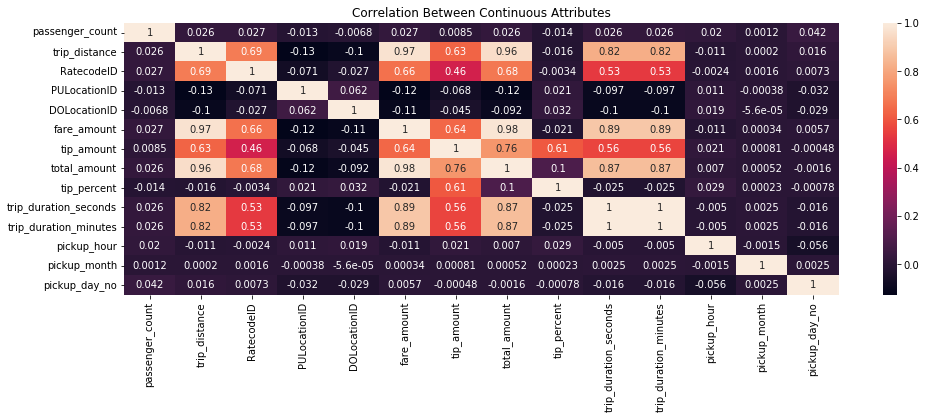

In [52]:
col = ['trip_distance', 'passenger_count' ,'fare_amount', 'tip_amount', 'total_amount', 'trip_duration_minutes', 'pickup_day_no', 'pickup_month', 'pickup_hour', 'total_amount']
#label = ['Distance', 'Fare', 'Tip', 'Total$', 'Duration', '', '']

# plot correlation plot
fig, ax = plt.subplots(figsize=(16, 5))
corr_matrix = df_taxi.corr()
sns.heatmap(corr_matrix, annot=True, ax=ax)
ax.set_title("Correlation Between Continuous Attributes")
plt.show()

## Regression models

In [16]:
#select only the necessary columns as X
#Datetime not included, due to dtype
X = df_taxi_sampled[["PULocationID", "DOLocationID", "trip_distance", "passenger_count","fare_amount","tip_amount","trip_duration_minutes","pickup_day_no","pickup_month","pickup_hour",]]

In [10]:
X.dtypes

PULocationID                      int64
DOLocationID                      int64
trip_distance                   float64
passenger_count                 float64
fare_amount                     float64
tip_amount                      float64
trip_duration_minutes           float64
pickup_day_no                     int64
pickup_month                      int64
pickup_hour                       int64
tpep_pickup_datetime     datetime64[ns]
dtype: object

In [11]:
y = df_taxi_sampled["total_amount"]

In [12]:
y.dtype

dtype('float64')

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

In [18]:
X_train.columns

Index(['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count',
       'fare_amount', 'tip_amount', 'trip_duration_minutes', 'pickup_day_no',
       'pickup_month', 'pickup_hour'],
      dtype='object')

### Random forest prediction

In [19]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)

In [20]:
print(rf_predict)

[13.56   25.3215  9.9382 ... 20.1564 11.4599 24.3639]


In [22]:
rf.score(X_test, y_test)

0.992618181396748

### Gradiënt boosting with LightGBM

In [24]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': -1,
        'verbose': 0,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'subsample_freq': 1,
        'colsample_bytree': 0.6,
        'reg_aplha': 1,
        'reg_lambda': 0.001,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1     
    }

In [25]:
pred_test_y = np.zeros(X_test.shape[0])
pred_test_y.shape

(2000,)

In [26]:
train_set = lgbm.Dataset(X_train, y_train, silent=True)
train_set

In [27]:
#reset to 300 boosting rounds
model = lgbm.train(params, train_set = train_set, num_boost_round=50)

[LightGBM] [Warning] Unknown parameter: reg_aplha
[LightGBM] [Warning] Unknown parameter: reg_aplha
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\Daphne\Anaconda3\lib\site-packages\lightgbm\basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


In [28]:
pred_test_y = model.predict(X_test, num_iteration = model.best_iteration)

In [29]:
print(pred_test_y)

[14.08227492 25.59408855 11.21054241 ... 20.02795037 12.31467793
 24.21225963]


In [42]:
# ALTERNATIVE MODEL?

# fit the model
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
# predict and evaluate

gbr_train_pred = reg.predict(X_train)
gbr_test_pred = reg.predict(X_test)
train_rmse = mean_squared_error(y_train, gbr_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, gbr_test_pred, squared=False)
train_r2 = r2_score(y_train, gbr_train_pred)
test_r2 = r2_score(y_test, gbr_test_pred)

print("Gradient Boost Regression")
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R2", train_r2)
print("Test R2", test_r2)

Gradient Boost Regression
Train RMSE: 0.9761781460231322
Test RMSE: 1.2346828627443112
Train R2 0.9950983939778293
Test R2 0.9925422327981775


In [43]:
reg.feature_importances_

array([5.12610361e-04, 1.81155984e-04, 1.12433962e-01, 0.00000000e+00,
       8.39641990e-01, 4.62776665e-02, 1.83845198e-04, 1.88249231e-04,
       0.00000000e+00, 5.80520681e-04])

### Gradiënt boosting with XGBoost

In [34]:
#!pip install xgboost

In [36]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
#dtest = xgb.DMatrix(test_df)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_params = {
    'min_child_weight': 1, 
    'learning_rate': 0.05, 
    'colsample_bytree': 0.7, 
    'max_depth': 10,
    'subsample': 0.7,
    'n_estimators': 50, #set back to 5000
    'n_jobs': -1, 
    'booster' : 'gbtree', 
    'silent': 1,
    'eval_metric': 'rmse'}

model = xgb.train(xgb_params, dtrain, 700, watchlist, early_stopping_rounds=100, maximize=False, verbose_eval=50)

[13:44:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:22.67050	valid-rmse:23.09304


C:\Users\Daphne\Anaconda3\lib\site-packages\xgboost\core.py:528: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning


[50]	train-rmse:2.10901	valid-rmse:2.32612
[100]	train-rmse:0.49400	valid-rmse:1.12713
[150]	train-rmse:0.29331	valid-rmse:1.07660
[200]	train-rmse:0.22334	valid-rmse:1.07020
[250]	train-rmse:0.17742	valid-rmse:1.06559
[300]	train-rmse:0.13802	valid-rmse:1.06270
[350]	train-rmse:0.10780	valid-rmse:1.06190
[400]	train-rmse:0.08521	valid-rmse:1.06068
[450]	train-rmse:0.06784	valid-rmse:1.06027
[500]	train-rmse:0.05372	valid-rmse:1.05984
[550]	train-rmse:0.04358	valid-rmse:1.05955
[600]	train-rmse:0.03487	valid-rmse:1.05946
[650]	train-rmse:0.02841	valid-rmse:1.05929
[699]	train-rmse:0.02302	valid-rmse:1.05918


In [37]:
y_train_pred = model.predict(dtrain)
y_pred = model.predict(dvalid)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  0.9999972730593839
Test r2 score:  0.9945116691511294
Train RMSE: 0.0230
Test RMSE: 1.0592


## Classification models

In [53]:
df_taxi.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,...,pickup_time,dropoff_time,trip_duration_seconds,trip_duration_minutes,pickup_hour,pickup_month,pickup_day_no,day_of_week,pickup_zone,dropoff_zone
0,2022-03-01 00:13:08,2022-03-01 00:24:35,1.0,2.40,1.0,90,209,10.0,0.00,13.80,...,00:13:08,00:24:35,687.0,11.0,0,3,1,Weekday,Flatiron,Seaport
1,2022-03-01 00:47:52,2022-03-01 01:00:08,1.0,2.20,1.0,148,234,10.5,0.00,14.30,...,00:47:52,01:00:08,736.0,12.0,0,3,1,Weekday,Lower East Side,Union Sq
2,2022-03-01 00:02:46,2022-03-01 00:46:43,1.0,19.78,2.0,132,249,52.0,11.06,67.61,...,00:02:46,00:46:43,2637.0,43.0,0,3,1,Weekday,JFK Airport,West Village
3,2022-03-01 00:52:43,2022-03-01 01:03:40,2.0,2.94,1.0,211,66,11.0,4.44,19.24,...,00:52:43,01:03:40,657.0,10.0,0,3,1,Weekday,SoHo,DUMBO/Vinegar Hill
4,2022-03-01 00:15:35,2022-03-01 00:34:13,1.0,8.57,1.0,138,197,25.0,5.51,33.06,...,00:15:35,00:34:13,1118.0,18.0,0,3,1,Weekday,LaGuardia Airport,Richmond Hill


In [54]:
print(df_taxi["total_amount"].max())
print(df_taxi["total_amount"].min())
print(df_taxi["total_amount"].mean())

183.17
3.3
19.877002669778406


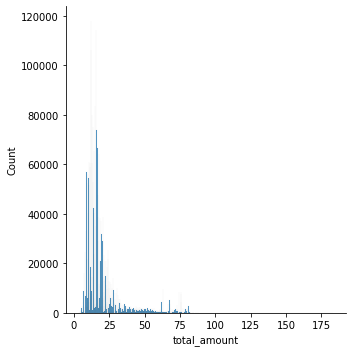

In [55]:
import seaborn as sns
sns.displot(df_taxi, x="total_amount")

In [56]:
df_taxi.sort_values('total_amount')

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,...,pickup_time,dropoff_time,trip_duration_seconds,trip_duration_minutes,pickup_hour,pickup_month,pickup_day_no,day_of_week,pickup_zone,dropoff_zone
274785,2022-03-03 13:34:10,2022-03-03 13:35:46,1.0,0.03,1.0,130,130,2.5,0.00,3.30,...,13:34:10,13:35:46,96.0,1.0,13,3,3,Weekday,Jamaica,Jamaica
801997,2022-03-08 09:04:53,2022-03-08 09:10:16,1.0,0.08,1.0,244,244,2.5,0.00,3.30,...,09:04:53,09:10:16,323.0,5.0,9,3,1,Weekday,Washington Heights South,Washington Heights South
1058238,2022-03-10 13:25:51,2022-03-10 15:08:03,1.0,0.30,1.0,193,145,2.5,0.00,3.30,...,13:25:51,15:08:03,6132.0,102.0,13,3,3,Weekday,Queensbridge/Ravenswood,Long Island City/Hunters Point
2614228,2022-03-24 13:43:50,2022-03-24 14:01:15,1.0,0.46,1.0,166,42,2.5,0.00,3.30,...,13:43:50,14:01:15,1045.0,17.0,13,3,3,Weekday,Morningside Heights,Central Harlem North
1501988,2022-03-14 12:18:35,2022-03-14 12:19:48,1.0,0.14,1.0,166,166,2.5,0.00,3.30,...,12:18:35,12:19:48,73.0,1.0,12,3,0,Weekday,Morningside Heights,Morningside Heights
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818131,2022-03-08 12:54:09,2022-03-08 14:08:03,1.0,37.83,1.0,68,229,103.5,29.98,149.88,...,12:54:09,14:08:03,4434.0,73.0,12,3,1,Weekday,East Chelsea,Sutton Place/Turtle Bay North
3032498,2022-03-27 23:58:00,2022-03-28 01:23:31,1.0,46.84,1.0,132,132,128.5,25.96,157.01,...,23:58:00,01:23:31,5131.0,85.0,23,3,0,Weekend,JFK Airport,JFK Airport
229883,2022-03-03 01:52:06,2022-03-03 03:49:06,1.0,47.30,1.0,113,260,135.0,0.00,158.45,...,01:52:06,03:49:06,7020.0,117.0,1,3,3,Weekday,Greenwich Village North,Woodside
2190142,2022-03-20 14:02:00,2022-03-20 14:51:23,1.0,37.26,1.0,243,44,97.0,37.26,161.46,...,14:02:00,14:51:23,2963.0,49.0,14,3,6,Weekend,Washington Heights North,Charleston/Tottenville


In [72]:
#creating categories
#spread evenly over categories?
df_taxi['bins'] = pd.cut(x=df_taxi['total_amount'], bins=[1, 25, 50, 75, 100, 200])
df_taxi.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,...,dropoff_time,trip_duration_seconds,trip_duration_minutes,pickup_hour,pickup_month,pickup_day_no,day_of_week,pickup_zone,dropoff_zone,bins
0,2022-03-01 00:13:08,2022-03-01 00:24:35,1.0,2.40,1.0,90,209,10.0,0.00,13.80,...,00:24:35,687.0,11.0,0,3,1,Weekday,Flatiron,Seaport,"(1, 25]"
1,2022-03-01 00:47:52,2022-03-01 01:00:08,1.0,2.20,1.0,148,234,10.5,0.00,14.30,...,01:00:08,736.0,12.0,0,3,1,Weekday,Lower East Side,Union Sq,"(1, 25]"
2,2022-03-01 00:02:46,2022-03-01 00:46:43,1.0,19.78,2.0,132,249,52.0,11.06,67.61,...,00:46:43,2637.0,43.0,0,3,1,Weekday,JFK Airport,West Village,"(50, 75]"
3,2022-03-01 00:52:43,2022-03-01 01:03:40,2.0,2.94,1.0,211,66,11.0,4.44,19.24,...,01:03:40,657.0,10.0,0,3,1,Weekday,SoHo,DUMBO/Vinegar Hill,"(1, 25]"
4,2022-03-01 00:15:35,2022-03-01 00:34:13,1.0,8.57,1.0,138,197,25.0,5.51,33.06,...,00:34:13,1118.0,18.0,0,3,1,Weekday,LaGuardia Airport,Richmond Hill,"(25, 50]"


In [73]:
#renaming categories
df_taxi['bins'] = df_taxi['bins'].cat.rename_categories(["Low", "Medium","High","Very High","Extremely High"])
df_taxi.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,...,dropoff_time,trip_duration_seconds,trip_duration_minutes,pickup_hour,pickup_month,pickup_day_no,day_of_week,pickup_zone,dropoff_zone,bins
0,2022-03-01 00:13:08,2022-03-01 00:24:35,1.0,2.40,1.0,90,209,10.0,0.00,13.80,...,00:24:35,687.0,11.0,0,3,1,Weekday,Flatiron,Seaport,Low
1,2022-03-01 00:47:52,2022-03-01 01:00:08,1.0,2.20,1.0,148,234,10.5,0.00,14.30,...,01:00:08,736.0,12.0,0,3,1,Weekday,Lower East Side,Union Sq,Low
2,2022-03-01 00:02:46,2022-03-01 00:46:43,1.0,19.78,2.0,132,249,52.0,11.06,67.61,...,00:46:43,2637.0,43.0,0,3,1,Weekday,JFK Airport,West Village,High
3,2022-03-01 00:52:43,2022-03-01 01:03:40,2.0,2.94,1.0,211,66,11.0,4.44,19.24,...,01:03:40,657.0,10.0,0,3,1,Weekday,SoHo,DUMBO/Vinegar Hill,Low
4,2022-03-01 00:15:35,2022-03-01 00:34:13,1.0,8.57,1.0,138,197,25.0,5.51,33.06,...,00:34:13,1118.0,18.0,0,3,1,Weekday,LaGuardia Airport,Richmond Hill,Medium


In [74]:
df_taxi['bins'].dtype

CategoricalDtype(categories=['Low', 'Medium', 'High', 'Very High', 'Extremely High'], ordered=True)

In [75]:
df_taxi_sampled_2 = df_taxi.sample(n=10000)

In [76]:
X2 = df_taxi_sampled_2[["PULocationID", "DOLocationID", "trip_distance", "passenger_count","tip_amount","trip_duration_minutes","pickup_day_no","pickup_month","pickup_hour",]]

In [ ]:
#lightgbm.LGBMClassifier

In [77]:
y2 = df_taxi_sampled_2["bins"]

In [83]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=25)

In [85]:
# evaluate lightgbm algorithm for classification
# define the model
model = LGBMClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train2, y_train2, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.959 (0.010)


#### Exploring the number of trees

In [96]:
# get a list of models to evaluate
def get_models():
	models = dict()
	trees = [3, 5, 7, 9, 11, 13]
	for n in trees:
		models[str(n)] = LGBMClassifier(n_estimators=n)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X_train2, y_train2, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>3 0.921 (0.022)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>5 0.969 (0.006)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>7 0.974 (0.005)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>9 0.977 (0.006)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>11 0.977 (0.005)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>13 0.977 (0.004)


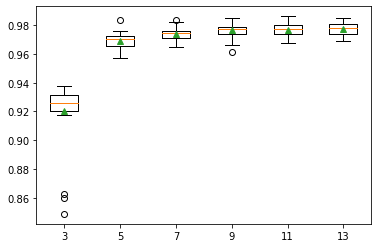

In [99]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

#### Exploring the tree depth

C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>1 0.977 (0.006)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>2 0.979 (0.005)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>3 0.968 (0.034)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>4 0.970 (0.007)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>5 0.968 (0.008)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>6 0.963 (0.011)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>7 0.960 (0.013)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>8 0.959 (0.010)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>9 0.957 (0.011)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>10 0.955 (0.010)


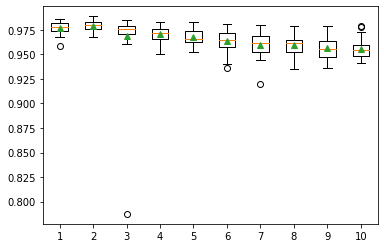

In [100]:
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1,11):
		models[str(i)] = LGBMClassifier(max_depth=i, num_leaves=2**i)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X_train2, y_train2, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

#### Exploring Boosting type

C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>gbdt 0.959 (0.010)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>dart 0.971 (0.007)


C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Daphne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>goss 0.969 (0.009)


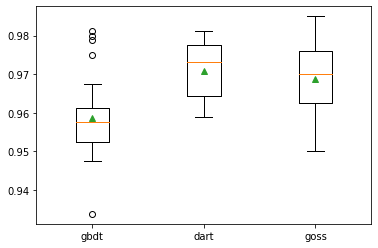

In [101]:
# get a list of models to evaluate
def get_models():
	models = dict()
	types = ['gbdt', 'dart', 'goss']
	for t in types:
		models[t] = LGBMClassifier(boosting_type=t)
	return models


# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

#### Final model predictions

In [103]:
#FINAL MODEL, MAKE PREDICTIONS
# make predictions using lightgbm for classification
model = LGBMClassifier()
# fit the model on the whole dataset
model.fit(X_test2, y_test2)
# make a single prediction
yhat = model.predict(X_test2)

In [104]:
yhat

array(['Low', 'Medium', 'Low', ..., 'Low', 'Low', 'Low'], dtype=object)

In [105]:
X_test['predicted_class'] = yhat

C:\Users\Daphne\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [106]:
X_test

,PULocationID,DOLocationID,trip_distance,passenger_count,fare_amount,tip_amount,trip_duration_minutes,pickup_day_no,pickup_month,pickup_hour,predicted_class
1897413,113,107,1.46,1.0,7.5,2.26,9.0,3,3,22,Low
1998173,161,231,4.34,1.0,21.5,0.00,29.0,4,3,19,Medium
501042,239,143,0.50,1.0,4.5,2.00,5.0,5,3,10,Low
1812675,237,236,1.00,1.0,8.5,2.00,12.0,3,3,10,Medium
47378,125,170,2.33,1.0,12.0,0.00,16.0,1,3,14,Low
...,...,...,...,...,...,...,...,...,...,...,...
1927369,137,249,2.20,1.0,11.0,3.55,13.0,4,3,9,Low
1886531,249,48,3.30,1.0,14.5,4.55,19.0,3,3,21,High
2994165,161,144,2.69,1.0,13.5,3.36,17.0,6,3,16,Low
2113114,263,141,1.40,1.0,6.5,1.47,6.0,5,3,19,Low


In [125]:
data = X2.columns.to_list()
df = pd.DataFrame(data, columns=['Features'])
df['Importance'] = model.feature_importances_
df

,Features,Importance
0,PULocationID,670
1,DOLocationID,1222
2,trip_distance,2895
3,passenger_count,99
4,tip_amount,2577
5,trip_duration_minutes,2177
6,pickup_day_no,429
7,pickup_month,0
8,pickup_hour,716


In [128]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

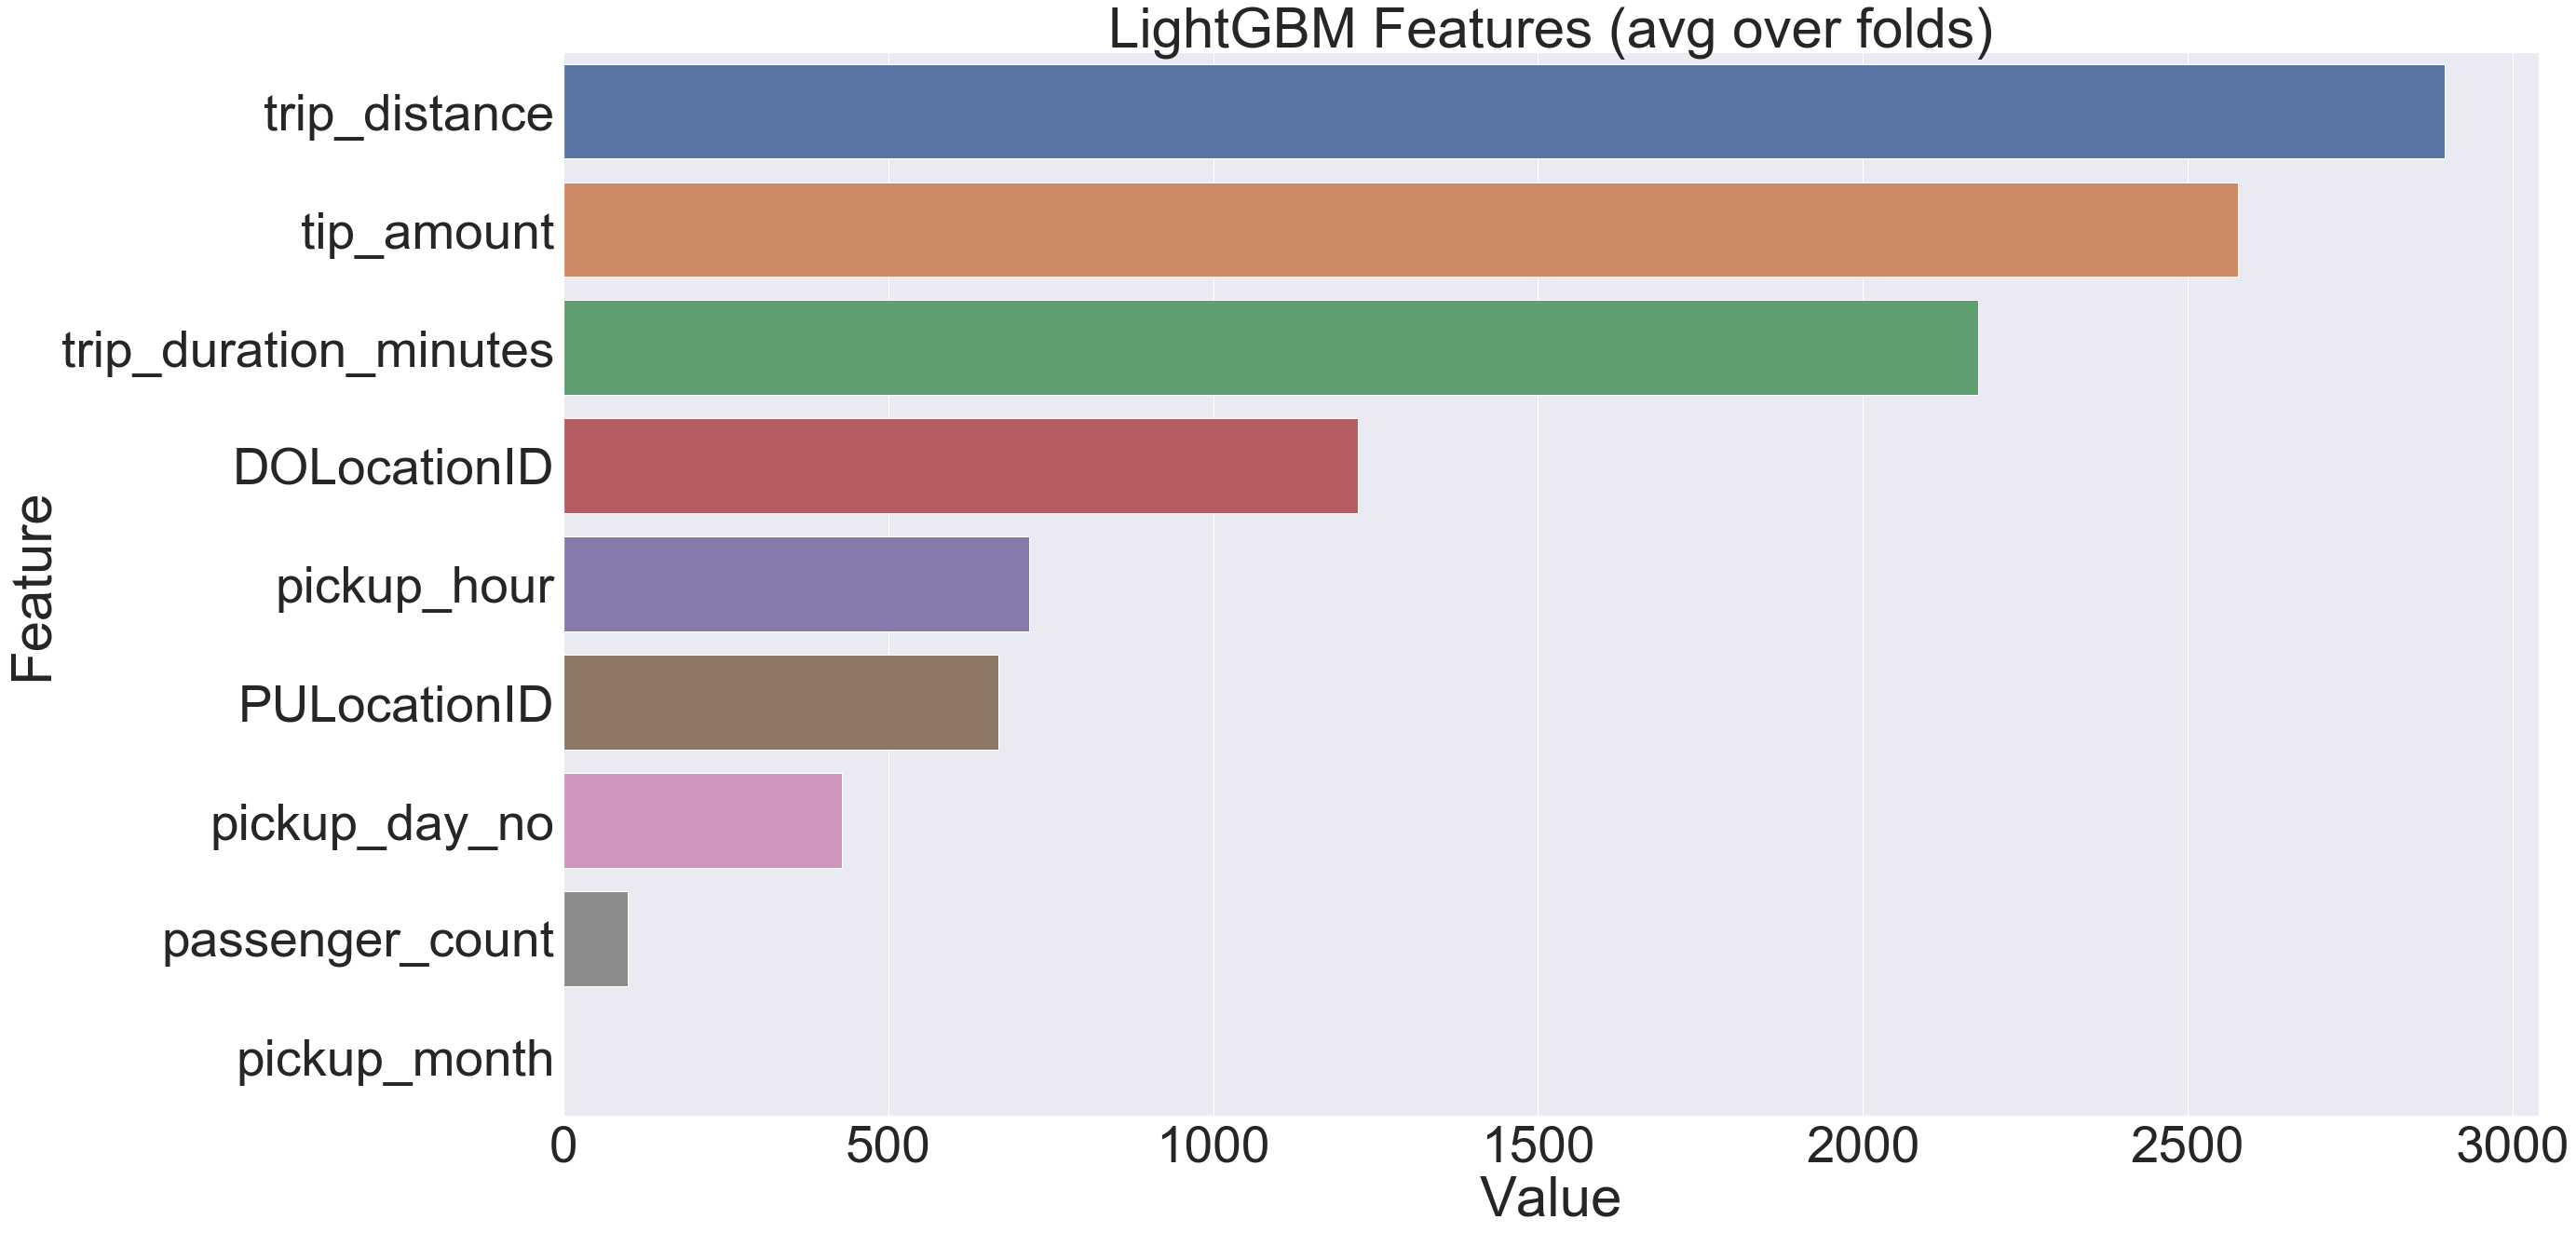

In [129]:
plotImp(model, X_test2)

## Predicting trip_distance

In [151]:
#select only the necessary columns as X
X = df_taxi_sampled[['passenger_count', 'PULocationID', 'DOLocationID',
       'fare_amount', 'tip_amount', 'total_amount', 'tip_percent',
       'trip_duration_minutes', 'pickup_hour',
       'pickup_month', 'pickup_day_no']]

In [152]:
X.dtypes

passenger_count          float64
PULocationID               int64
DOLocationID               int64
fare_amount              float64
tip_amount               float64
total_amount             float64
tip_percent              float64
trip_duration_minutes    float64
pickup_hour                int64
pickup_month               int64
pickup_day_no              int64
dtype: object

In [153]:
y = df_taxi_sampled["trip_distance"]

In [154]:
y.dtype

dtype('float64')

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

#### Random forest prediction

In [156]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)

In [157]:
X_test['predicted_distance'] = rf_predict
X_test

C:\Users\Daphne\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,passenger_count,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,tip_percent,trip_duration_minutes,pickup_hour,pickup_month,pickup_day_no,predicted_distance
1897413,1.0,113,107,7.5,2.26,13.56,16.666667,9.0,22,3,3,0.9864
1998173,1.0,161,231,21.5,0.00,25.80,0.000000,29.0,19,3,4,4.6225
501042,1.0,239,143,4.5,2.00,9.80,20.408163,5.0,10,3,5,0.5003
1812675,1.0,237,236,8.5,2.00,13.80,14.492754,12.0,10,3,3,0.8738
47378,1.0,125,170,12.0,0.00,15.30,0.000000,16.0,14,3,1,2.4276
...,...,...,...,...,...,...,...,...,...,...,...,...
1927369,1.0,137,249,11.0,3.55,17.85,19.887955,13.0,9,3,4,2.2917
1886531,1.0,249,48,14.5,4.55,22.85,19.912473,19.0,21,3,3,3.2943
2994165,1.0,161,144,13.5,3.36,20.16,16.666667,17.0,16,3,6,3.0361
2113114,1.0,263,141,6.5,1.47,11.27,13.043478,6.0,19,3,5,1.2395


In [158]:
print(rf_predict)

[0.9864 4.6225 0.5003 ... 3.0361 1.2395 3.1408]


In [160]:
rf.score(X_test, y_test)

ValueError: Number of features of the model must match the input. Model n_features is 11 and input n_features is 12 